# Cost-Sensitive Threshold Optimization

### Why Threshold Tuning?

In fraud detection, the default probability threshold (0.5) is rarely optimal.

- Missing fraud (False Negative) causes **direct financial loss**
- Blocking legitimate users (False Positive) causes **customer dissatisfaction**

Therefore, we choose a threshold that **minimizes business cost**, not one that maximizes accuracy.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [3]:
# Load Model Results
results = pd.read_csv('../data/results.csv') 

results.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31_missing,id_32_missing,id_33_missing,id_34_missing,id_35_missing,id_36_missing,id_37_missing,id_38_missing,is_fraud,risk_score
0,57.95,4,7919,194.0,150.0,2,166.0,2,143.0,87.0,...,1,1,1,1,1,1,1,1,0,0.006633
1,47.95,4,1764,158.0,150.0,4,226.0,2,315.0,87.0,...,1,1,1,1,1,1,1,1,0,0.115170
2,209.95,4,2455,321.0,150.0,4,226.0,1,225.0,87.0,...,1,1,1,1,1,1,1,1,0,0.275809
3,107.95,4,7919,194.0,150.0,2,166.0,2,126.0,87.0,...,1,1,1,1,1,1,1,1,0,0.035903
4,58.95,4,10838,143.0,150.0,4,226.0,2,205.0,87.0,...,1,1,1,1,1,1,1,1,0,0.036681


In [4]:
# Extract Target & Risk Scores
y_test = results['is_fraud'].values
y_proba = results['risk_score'].values

assert len(y_test) == len(y_proba)

In [5]:
# Define Business Costs
COST_FN = 1000  # Missed fraud (money lost)
COST_FP = 10    # Legit transaction flagged (customer friction)

# Threshold Gird
thresholds = np.linspace(0.01, 0.99, 99)

# Cost Evaluation Function
def compute_cost(y_true, y_proba, threshold, cost_fn, cost_fp):
    y_pred = (y_proba >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    total_cost = (fn * cost_fn) + (fp * cost_fp)

    return {
        "threshold": threshold,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "tn": tn,
        "total_cost": total_cost
    }

In [6]:
# Evaluate All Thresholds

results = []

for t in thresholds:
    results.append(
        compute_cost(
            y_test,
            y_proba,
            threshold=t,
            cost_fn=COST_FN,
            cost_fp=COST_FP
        )
    )

results_df = pd.DataFrame(results)
results_df.head()

,threshold,fp,fn,tp,tn,total_cost
0,0.01,84847,0,3083,651,848470
1,0.02,82656,1,3082,2842,827560
2,0.03,79546,9,3074,5952,804460
3,0.04,76114,21,3062,9384,782140
4,0.05,72604,36,3047,12894,762040


In [7]:
# Find Optimal Threshold 
best_row = results_df.loc[results_df["total_cost"].idxmin()]
best_row


threshold          0.18
fp             35512.00
fn               214.00
tp              2869.00
tn             49986.00
total_cost    569120.00
Name: 17, dtype: float64

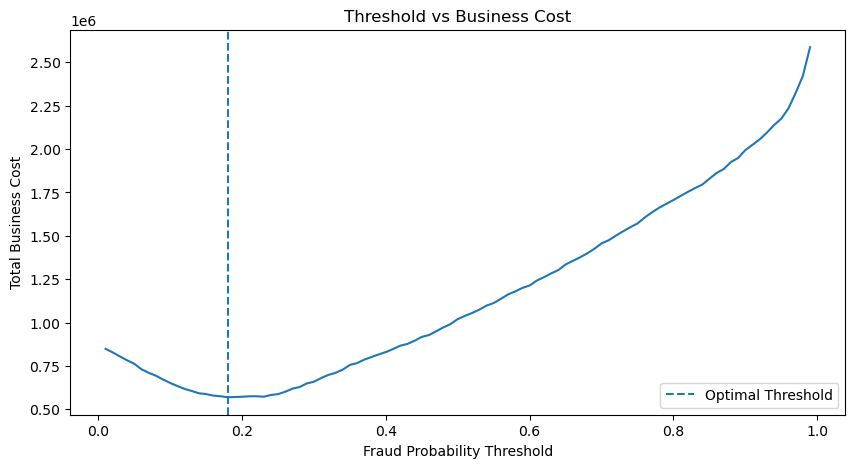

In [8]:
# Visualize Cost Curve
plt.figure(figsize=(10, 5))
plt.plot(results_df["threshold"], results_df["total_cost"])
plt.axvline(best_row["threshold"], linestyle="--", label="Optimal Threshold")
plt.xlabel("Fraud Probability Threshold")
plt.ylabel("Total Business Cost")
plt.title("Threshold vs Business Cost")
plt.legend()
plt.show()


In [9]:
# Compare With Default Threshold (0.5)
default = results_df.loc[
    results_df["threshold"] == results_df.iloc[
        (results_df["threshold"] - 0.5).abs().argsort()[:1]
    ]["threshold"].values[0]
]



print("Default Threshold Cost:", default["total_cost"])
print("Optimized Threshold Cost:", best_row["total_cost"])


Default Threshold Cost: 49    1019780
Name: total_cost, dtype: int64
Optimized Threshold Cost: 569120.0


In [10]:
optimal_threshold = best_row["threshold"]

y_pred_opt = (y_proba >= optimal_threshold).astype(int)

confusion_matrix(y_test, y_pred_opt)


array([[49986, 35512],
       [  214,  2869]])

### Key Takeaways

- ROC-AUC showed the model ranked transactions very well
- Threshold tuning converted ranking power into real business value
- Using cost-sensitive optimization reduced total fraud loss significantly

This approach aligns with how real banks and payment providers deploy fraud models.
